### Install dependencies

In [1]:
!pip install folium pandas
!pip install shapely

In [3]:
import boto3
import pandas as pd
import io
from botocore.exceptions import ClientError
from shapely.geometry import Point, Polygon
import math
import folium
from folium import plugins
import numpy as np
import folium
import pandas as pd
from typing import Optional, Union, Tuple
import json
from ipywidgets import interact, FloatSlider, Layout
import ipywidgets as widgets
from shapely.vectorized import contains
import s3fs

### Read Data

In [4]:
# Initialize boto3 session and get credentials
session = boto3.Session()
credentials = session.get_credentials()

# Initialize S3 filesystem with boto3 credentials
s3 = s3fs.S3FileSystem(
    key=credentials.access_key,
    secret=credentials.secret_key,
    token=credentials.token,  # This will be included if using temporary credentials
    anon=False
)
# Read the parquet file
s3_path = 's3://birdsbucker/Pipeline_Outputs/output_6ff24b78-4d86-4453-9a84-032d30a10854/part-00000-a03252eb-99f3-41d5-b2a1-4f0abd303539-c000.parquet'
df_birds = pd.read_parquet(s3_path, filesystem=s3)

df_birds.head()

,state_code,station_id,year_record,month_record,day_record,day_of_week,latitude_0,longitude_0,station_location,state,...,OBSERVATION DATE_month,OBSERVATION DATE_day,TimeObservationStarted_hour,TimeObservationStarted_minute,distance_to_station_160005,distance_to_station_140004,distance_to_station_160308,distance_to_station_060170,distance_to_station_792625,assigned_station
0,51,160005,2023,6,30,6,38.13873,-77.50837,5.85 S RAMP FR RT 1 ...,VA,...,0,19,14,0,5.323592,40.842887,33.085488,7.701909,22.943019,160005
1,51,160005,2023,6,29,5,38.13873,-77.50837,5.85 S RAMP FR RT 1 ...,VA,...,0,19,14,0,5.323592,40.842887,33.085488,7.701909,22.943019,160005
2,51,160005,2023,6,28,4,38.13873,-77.50837,5.85 S RAMP FR RT 1 ...,VA,...,0,19,14,0,5.323592,40.842887,33.085488,7.701909,22.943019,160005
3,51,160005,2023,6,27,3,38.13873,-77.50837,5.85 S RAMP FR RT 1 ...,VA,...,0,19,14,0,5.323592,40.842887,33.085488,7.701909,22.943019,160005
4,51,160005,2023,6,26,2,38.13873,-77.50837,5.85 S RAMP FR RT 1 ...,VA,...,0,19,14,0,5.323592,40.842887,33.085488,7.701909,22.943019,160005


### Support Functions

#### Create point layer

In [35]:
##v2
def create_point_layer(df, latitude, longitude, id, bird_observations, traffic_noise):
    """
    Create a feature group with points scaled by bird observations and colored by traffic noise.
    
    Args:
        df (pd.DataFrame): DataFrame containing the point data
        latitude (str): Name of latitude column
        longitude (str): Name of longitude column
        id (str): Name of ID column
        bird_observations (str): Name of bird observations column
        traffic_noise (str): Name of traffic noise column
    
    Returns:
        folium.FeatureGroup: Layer containing all points
    """
    # Create feature group
    point_layer = folium.FeatureGroup(name='Observation Points')

    # Remove any NaN values
    df = df.dropna(subset=[bird_observations, traffic_noise])
    
    if len(df) == 0:
        return point_layer
    
    # Calculate scales for size and color
    min_birds = df[bird_observations].min()
    max_birds = df[bird_observations].max()
    min_noise = df[traffic_noise].min()
    max_noise = df[traffic_noise].max()
    
    # Create scaling functions
    def scale_radius(value):
        # Scale radius between 5 and 25 pixels
        return 5 + ((value - min_birds) / (max_birds - min_birds)) * 20
    
    def scale_color(value):
        # Create color scale from green (quiet) to red (noisy)
        normalized = (value - min_noise) / (max_noise - min_noise)
        return f'#{int(255 * normalized):02x}{int(255 * (1-normalized)):02x}00'
    
    # Add points to layer
    for idx, row in df.iterrows():
        # Calculate radius and color
        radius = scale_radius(row[bird_observations])
        color = scale_color(row[traffic_noise])
        
        # Create popup content
        popup_content = f"""
            <b>Station ID:</b> {row[id]}<br>
            <b>Bird Observations:</b> {row[bird_observations]}<br>
            <b>Traffic Noise:</b> {row[traffic_noise]:.2f}<br>
        """
        
        # Add circle marker
        folium.CircleMarker(
            location=[row[latitude], row[longitude]],
            radius=radius,
            popup=folium.Popup(popup_content, max_width=300),
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f"Station {row[id]}"
        ).add_to(point_layer)
    
    # Add legend for size
    legend_html = f"""
        <div style="position: fixed; 
                    bottom: 50px; right: 50px; width: 150px; height: 90px; 
                    border:2px solid grey; z-index:9999; background-color:white;
                    padding: 10px;
                    font-size: 14px;">
            <p><b>Legend:</b></p>
            <p>🔴 Size: Bird Observations<br>
               ({min_birds:.0f} - {max_birds:.0f})</p>
            <p>🎨 Color: Traffic Noise<br>
               ({min_noise:.1f} - {max_noise:.1f})</p>
        </div>
    """
    point_layer.add_child(folium.Element(legend_html))
    
    return point_layer

#### Add point to map 

In [36]:
def add_df_point_to_map(df, m):
    """
    Add points from DataFrame to map with size and color based on total_birds
    
    Parameters:
    df: DataFrame containing latitude, longitude, and total_birds
    m: folium Map object
    
    Returns:
    feature_group: Folium FeatureGroup containing all markers
    """

    min_birds = df['total_birds'].min()
    max_birds = df['total_birds'].max()
    
    # Create a feature group for the data points
    feature_group = folium.FeatureGroup(name='Bird Observations')
    
    # Add points to feature group
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Long']],
            radius=scale_radius(row['total_birds'], min_birds, max_birds),
            color=get_color(row['total_birds']),
            fill=True,
            fill_color=get_color(row['total_birds']),
            fill_opacity=0.7,
            popup=f"Total Birds: {row['total_birds']}",
            tooltip=f"Location: ({row['Lat']:.2f}, {row['Long']:.2f})\nTotal Birds: {row['total_birds']}"
        ).add_to(feature_group)
    
    # Add the feature group to the map
    feature_group.add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color: white;
                padding: 10px;
                border-radius: 5px;
                ">
    <p><b>Bird Count Legend</b></p>
    <p>
    <i class="fa fa-circle" style="color:blue"></i> Low<br>
    <i class="fa fa-circle" style="color:yellow"></i> Medium<br>
    <i class="fa fa-circle" style="color:orange"></i> High<br>
    <i class="fa fa-circle" style="color:red"></i> Very High
    </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Return the feature group
    return feature_group

#### Slicers for noise and observations

In [41]:
def create_filtered_layer(noise_threshold, bird_threshold, df):
    """
    Create a feature group with points filtered by both noise and bird observation thresholds
    
    Args:
        noise_threshold (float): Maximum noise level threshold
        bird_threshold (float): Minimum bird observations threshold
        df (pd.DataFrame): DataFrame with station data
    
    Returns:
        folium.FeatureGroup: Filtered point layer
    """
    # Filter data based on both thresholds
    filtered_df = df[
        (df['daily_avg_noise'] <= noise_threshold) & 
        (df['bird_observations'] >= bird_threshold)
    ]
    
    # Create and return filtered point layer
    return create_point_layer(
        df=filtered_df,
        latitude='latitude',
        longitude='longitude',
        id='station_id',
        bird_observations='bird_observations',
        traffic_noise='daily_avg_noise'
    )

### Processing
1. Coordinates for area in scope

In [47]:
##making sure longitudes are negative
stations['longitude'] = -abs(stations['longitude'])

In [48]:
applicable_stations=['160005', '060170', '792625', '160308', '140004', '140221']

In [49]:
scoped_stations = stations[stations['station_id'].isin(applicable_stations)]

In [50]:
scoped_stations= scoped_stations[['station_id',  'latitude', 'longitude']].drop_duplicates()

In [51]:
# Define the desired order
desired_order = ['160005', '060170', '792625', '160308', '140004', '140221']

# Convert the station_id to string type if it's not already
scoped_stations['station_id'] = scoped_stations['station_id'].astype(str)

# Method 1: Using reindex
scoped_stations = scoped_stations.set_index('station_id').reindex(desired_order).reset_index()

In [52]:
scoped_stations

,station_id,latitude,longitude
0,160005,38.13873,-77.50837
1,060170,38.12208,-77.51653
2,792625,37.98311,-77.49229
3,160308,37.89196,-77.45865
4,140004,37.82411,-77.45616
5,140221,37.75417,-77.45853


#### Route coordinates and stations coordinates

In [53]:
i95_detailed= scoped_stations[['latitude', 'longitude']]
i95_detailed

,latitude,longitude
0,38.13873,-77.50837
1,38.12208,-77.51653
2,37.98311,-77.49229
3,37.89196,-77.45865
4,37.82411,-77.45616
5,37.75417,-77.45853


#### Filtering Traffic data based on scoped stations

In [54]:
traffic = traffic[traffic['station_id'].isin(applicable_stations)]

In [55]:
# Calculate average noise levels by station including coordinates
station_noise_avg = (traffic.groupby('station_id')
                    .agg({
                        'daily_avg_noise': 'mean',
                        'longitude': 'first',  # Take first occurrence since coordinates are constant
                        'latitude': 'first'
                    })
                    .round(2)  # Round to 2 decimal places
                    .reset_index()
                    .sort_values('daily_avg_noise', ascending=False))

# Display results
print("Average Noise Levels by Station with Coordinates:")
print(station_noise_avg)

Average Noise Levels by Station with Coordinates:
  station_id  daily_avg_noise  longitude  latitude
2     160005            90.25     -77.51     38.14
1     140004            89.72     -77.46     37.82
3     160308            89.60     -77.46     37.89
0     060170            89.25     -77.52     38.12
4     792625            76.76     -77.49     37.98


#### Filter bird data based on scoped area

In [56]:
station_noise_avg.to_json('stationsInScope.json', orient='records', indent=4)

In [58]:
# Method 1: Basic reading
try:
    with open('stationsInScope.json', 'r', encoding='utf-8') as file:
        stations_data = json.load(file)
    print(json.dumps(stations_data, indent=2))  # Pretty print the data
except FileNotFoundError:
    print("File not found: stationsInScope.json")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

[
  {
    "station_id": "160005",
    "daily_avg_noise": 90.25,
    "longitude": -77.51,
    "latitude": 38.14
  },
  {
    "station_id": "140004",
    "daily_avg_noise": 89.72,
    "longitude": -77.46,
    "latitude": 37.82
  },
  {
    "station_id": "160308",
    "daily_avg_noise": 89.6,
    "longitude": -77.46,
    "latitude": 37.89
  },
  {
    "station_id": "060170",
    "daily_avg_noise": 89.25,
    "longitude": -77.52,
    "latitude": 38.12
  },
  {
    "station_id": "792625",
    "daily_avg_noise": 76.76,
    "longitude": -77.49,
    "latitude": 37.98
  }
]


#### Number of bird observations per station

In [28]:
np.random.seed(42)  # For reproducibility
station_noise_avg['bird_observations'] = np.random.randint(20, 301, size=len(station_noise_avg))
station_noise_avg

,station_id,daily_avg_noise,longitude,latitude,bird_observations
2,160005,90.25,-77.51,38.14,122
1,140004,89.72,-77.46,37.82,290
3,160308,89.60,-77.46,37.89,126
0,060170,89.25,-77.52,38.12,91
4,792625,76.76,-77.49,37.98,208


NameError: name 'stations_noise_avg' is not defined

#### Scoped area

In [29]:
top_coord = (38.20869849463392, -77.498061264592)    
bottom_coord = (37.69676499199098, -77.45031120265044)  
path_coordinates = list(zip(scoped_stations['latitude'], scoped_stations['longitude']))

# create bounded area and bounded polygon
bounded_area, bounded_polygon = create_bounded_polygon(
    top_coordinate=top_coord,
    bottom_coordinate=bottom_coord,
    path_coordinates=path_coordinates,
    buffer_miles=5,
    color='blue',
    fill_color='blue'
)

### Create Map

In [92]:

# Create a folium map centered on the middle of the path
center_lat = (top_coord[0] + bottom_coord[0]) / 2
center_lon = (top_coord[1] + bottom_coord[1]) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='openstreetmap'
)

bounded_area.add_to(m)

# Create a feature group for the detailed route
route_group = folium.FeatureGroup(name='I-95 Detailed Route')

# Draw I-95 as a line with the detailed coordinates
folium.PolyLine(
    path_coordinates,
    weight=3,
    color='blue',
    opacity=0.8,
    popup='Interstate 95'
).add_to(route_group)

stations_layer=create_point_layer(station_noise_avg,latitude='latitude', longitude='longitude', id= 'station_id',bird_observations='bird_observations', traffic_noise='daily_avg_noise' )
# bird_layer = add_df_point_to_map(df, m)

# Add additional map features with proper attribution
# folium.TileLayer('cartodbpositron', name='Light Map').add_to(m)
# folium.TileLayer('cartodbdark_matter', name='Dark Map').add_to(m)

# ESRI Terrain
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='ESRI Terrain'
).add_to(m)

# OpenTopoMap with attribution
folium.TileLayer(
    'OpenTopoMap',
    name='Topography',
    attr='Map data: &copy; OpenStreetMap contributors, &copy; OpenTopoMap'
).add_to(m)

# Add map controls
stations_layer.add_to(m)
# bird_layer.add_to(m)
plugins.Fullscreen().add_to(m)
plugins.MousePosition().add_to(m)
plugins.MeasureControl().add_to(m)
folium.LayerControl().add_to(m)

# Add a mini map
minimap = plugins.MiniMap()
m.add_child(minimap)

# Add a title
title_html = '''
<div style="position: fixed; 
    top: 10px; left: 50px; width: 200px; height: 50px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:16px; padding: 10px">
    <b>Highway Noise and Bird Observations</b>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
m.save('i95_detailed_route_map.html')

#### Create Slicers

In [81]:
# Create sliders
noise_slider = FloatSlider(
    value=station_noise_avg['daily_avg_noise'].mean(),
    min=station_noise_avg['daily_avg_noise'].min(),
    max=station_noise_avg['daily_avg_noise'].max(),
    step=0.5,
    description='Max Noise:',
    continuous_update=False,
    layout=Layout(width='500px')
)

bird_slider = FloatSlider(
    value=station_noise_avg['bird_observations'].mean(),
    min=station_noise_avg['bird_observations'].min(),
    max=station_noise_avg['bird_observations'].max(),
    step=5,
    description='Birds:',
    continuous_update=False,
    layout=Layout(width='500px')
)

In [91]:
# Create base map
m = folium.Map(
    location=[station_noise_avg['latitude'].mean(), 
              station_noise_avg['longitude'].mean()],
    zoom_start=10
)

# Add initial layer
filtered_layer = create_filtered_layer(
    noise_slider.value, 
    bird_slider.value,
    df=station_noise_avg  # Pass the original dataframe
)
filtered_layer.add_to(m)

def update_map(noise_threshold, bird_threshold):
    # Remove old layer using layer_name
    for layer in m._children.copy():
        if m._children[layer].layer_name == 'filtered_points':
            del m._children[layer]
            
    # Add new filtered layer
    new_layer = create_filtered_layer(
        noise_threshold, 
        bird_threshold,
        df=station_noise_avg  # Use the original dataframe
    )
    new_layer.add_to(m)
    display(m)

# Create interactive controls
interactive_controls = interact(
    update_map,
    noise_threshold=noise_slider,
    bird_threshold=bird_slider
)

# Add a mini map
minimap = plugins.MiniMap()
m.add_child(minimap)

# Add a title
title_html = '''
<div style="position: fixed; 
    top: 10px; left: 50px; width: 200px; height: 50px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:16px; padding: 10px">
    <b>Highway Noise and Bird Observations</b>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map
m.save('map_w_sliders.html')

/tmp/ipykernel_181/2368672039.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return 5 + ((value - min_birds) / (max_birds - min_birds)) * 20
/tmp/ipykernel_181/2368672039.py:39: RuntimeWarning: invalid value encountered in scalar divide
  normalized = (value - min_noise) / (max_noise - min_noise)


ValueError: cannot convert float NaN to integer

## Other stuff

In [ ]:
# Use the bounded_area polygon to filter your data
filtered_df = filter_by_bounded_area(df, bounded_polygon)

# If you need to filter the stations data:
filtered_stations = filter_by_bounded_area(scoped_stations, bounded_area)

# Print the number of points inside and outside the bounded area
print(f"Total points: {len(df)}")
print(f"Points inside bounded area: {len(filtered_df)}")
print(f"Points outside bounded area: {len(df) - len(filtered_df)}")

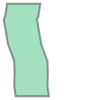

In [69]:
bounded_polygon

In [72]:


# Usage
save_polygon_to_json(bounded_polygon)

Successfully saved polygon to bounded_polygon.json


## Reading Parquet